Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/main/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
#else:
   #DATA_PATH = '../data/'

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix, classification_report
from category_encoders import OneHotEncoder, OrdinalEncoder

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# Module Project: Classification Metrics

This sprint, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

The tasks for this project are as follows:

- **Task 1:** Use `wrangle` function to import training and test data.
- **Task 2:** Split training data into feature matrix `X` and target vector `y`.
- **Task 3:** Split training data into training and validation sets.
- **Task 4:** Establish the baseline accuracy score for your dataset.
- **Task 5:** Build `model`.
- **Task 6:** Calculate the training and validation accuracy score for your model.
- **Task 7:** Plot the confusion matrix for your model.
- **Task 8:** Print the classification report for your model.
- **Task 9:** Identify likely `'non-functional'` pumps in the test set.
- **Task 10:** Find likely `'non-functional'` pumps serving biggest populations.
- **Task 11 (`stretch goal`):** Plot pump locations from Task 10.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `plotly`
- `sklearn`


# I. Wrangle Data

In [4]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, 
                            parse_dates=['date_recorded'], na_values=[0, -2.000000e-08]), 
                pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path,
                     parse_dates=['date_recorded'], 
                     na_values=[0, -2.000000e-08]).set_index('id')
    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)
    # Dropping high null columns
    df.drop(columns=['amount_tsh', 'num_private'], inplace=True)
    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)
    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)
    df['recorded_year'] = df['date_recorded'].dt.year
    df['recorded_month'] = df['date_recorded'].dt.month
    df['recorded_day'] = df['date_recorded'].dt.day
    df.drop(columns='date_recorded', inplace=True) 
    #feature engineering a new column
    df['pump_age'] = df['recorded_year'] - df['construction_year']     
    
    return df

**Task 1:** Using the above `wrangle` function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [5]:
train_feature_path = DATA_PATH+'waterpumps/train_features.csv'
train_target_path = DATA_PATH+'waterpumps/train_labels.csv'
test_feature_path = DATA_PATH+'waterpumps/test_features.csv'

In [6]:
df = wrangle(train_feature_path, train_target_path)
X_test = wrangle(test_feature_path)

# II. Split Data

**Task 2:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

**Note:** You won't need to do a train-test split because you'll use cross-validation instead.

In [7]:
def binary(status):
  if status == 'functional':
    return 0
  else:
    return 1
df['needs_repair_or_not'] = df['status_group'].apply(binary)

In [8]:
df['needs_repair_or_not'].value_counts()

0    32259
1    27140
Name: needs_repair_or_not, dtype: int64

In [9]:
target = 'status_group'
y = df[target]
X = df.drop(columns=[target, 'needs_repair_or_not'])

**Task 3:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
assert len(X_train) + len(X_val) == len(X)

# III. Establish Baseline

**Task 4:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [12]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5425829668132747


# IV. Build Models

**Task 5:** Build and train your `model`. Include the transformers and predictor that you think are most appropriate for this problem.

In [13]:
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=47,
                           n_jobs=-2,
                           random_state=42)
)

model.fit(X_train, y_train);

# V. Check Metrics

**Task 6:** Calculate the training and validation accuracy scores for `model`.

In [14]:
training_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.997032765841032
Validation Accuracy Score: 0.8033670033670034


**Task 7:** Plot the confusion matrix for your model, using your validation data.

**Note:** Since there are three classes in your target vector, the dimensions of your matrix will be 3x3.

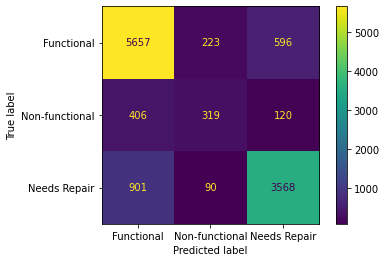

In [15]:
# Plot 3x3 confusion matrix
plot_confusion_matrix(model,
                      X_val,
                      y_val,
                      values_format='.0f',
                      display_labels=['Functional', 'Non-functional', 'Needs Repair'])

Calculating precision and recall for a multiclass problem is a bit of a mess. Fortunately, we can use `sklearn`'s classification report.

**Task 8:**  Print the classification report for your `model`, using your validation data.

In [16]:
# Print classification report 
print(classification_report(y_val, model.predict(X_val)))

                         precision    recall  f1-score   support

             functional       0.81      0.87      0.84      6476
functional needs repair       0.50      0.38      0.43       845
         non functional       0.83      0.78      0.81      4559

               accuracy                           0.80     11880
              macro avg       0.72      0.68      0.69     11880
           weighted avg       0.80      0.80      0.80     11880



# VI. Tune Model

Usually, we use this part of the ML workflow to adjust the hyperparameters of the our model to increase performance based on metrics like accuracy. Today, we'll use it to help maximize the impact of our water pump repairs when resources are scarce. What if we only had funds to repair 100 water pumps?

(This activity is based on a [post](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050) by Lambda alum Michael Brady.)

**Task 9:** Using your model's `predict_proba` method, identify the observations in your **test set** where the model is more than 95% certain that a pump is `'non-functional'`. Put these observations in the DataFrame `X_test_nf`.

In [17]:
y_train.value_counts()

functional                 25783
non functional             18264
functional needs repair     3472
Name: status_group, dtype: int64

In [18]:
#printing the first 10 values from our numpy array

#print(model.predict(y_pred_proba)[0:10])

In [19]:
# multi-classification problem
# always need the colon to locate/isolate a column from a ND(nomial dimension) array

X_test['y_predict'] = model.predict_proba(X_test)[:,-1]

X_test

,gps_height,longitude,latitude,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,recorded_year,recorded_month,recorded_day,pump_age,y_predict
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50785,1996.0,35.290799,-4.059696,Internal,Manyara,21,3.0,321.0,True,Parastatal,True,2012.0,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,2013,2,4,1.0,0.531915
51630,1569.0,36.656709,-3.309214,Pangani,Arusha,2,2.0,300.0,True,VWC,True,2000.0,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,2013,2,4,13.0,0.063830
17168,1567.0,34.767863,-5.004344,Internal,Singida,13,2.0,500.0,True,VWC,NaN,2010.0,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,2013,2,1,3.0,0.127660
45559,267.0,38.058046,-9.418672,Ruvuma / Southern Coast,Lindi,80,43.0,250.0,NaN,VWC,True,1987.0,other,other,vwc,user-group,unknown,unknown,soft,good,dry,shallow well,shallow well,groundwater,other,other,2013,1,22,26.0,1.000000
49871,1260.0,35.006123,-10.950412,Ruvuma / Southern Coast,Ruvuma,10,3.0,60.0,NaN,Water Board,True,2000.0,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2013,3,27,13.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39307,34.0,38.852669,-6.582841,Wami / Ruvu,Pwani,6,1.0,20.0,True,VWC,True,1988.0,mono,motorpump,vwc,user-group,never pay,never pay,soft,good,enough,river,river/lake,surface,communal standpipe,communal standpipe,2011,2,24,23.0,0.957447
18990,NaN,37.451633,-5.350428,Pangani,Tanga,4,7.0,2960.0,True,VWC,False,1994.0,nira/tanira,handpump,vwc,user-group,pay annually,annually,salty,salty,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,2011,3,21,17.0,0.127660
28749,1476.0,34.739804,-4.585587,Internal,Singida,13,2.0,200.0,True,VWC,NaN,2010.0,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,dam,dam,surface,communal standpipe,communal standpipe,2013,3,4,3.0,0.191489


In [20]:
X_test.shape

(14358, 31)

In [21]:
mask = X_test['y_predict'] > 0.95

X_test_nf = X_test[mask].copy()

X_test_nf

,gps_height,longitude,latitude,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,recorded_year,recorded_month,recorded_day,pump_age,y_predict
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
45559,267.0,38.058046,-9.418672,Ruvuma / Southern Coast,Lindi,80,43.0,250.0,NaN,VWC,True,1987.0,other,other,vwc,user-group,unknown,unknown,soft,good,dry,shallow well,shallow well,groundwater,other,other,2013,1,22,26.0,1.000000
28965,234.0,39.607420,-10.893786,Ruvuma / Southern Coast,Mtwara,9,4.0,1.0,True,Water Board,True,1982.0,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,2013,1,25,31.0,1.000000
45750,608.0,37.686392,-4.555975,Pangani,Manyara,21,4.0,500.0,True,NaN,True,2002.0,other,other,vwc,user-group,never pay,never pay,soft,good,dry,rainwater harvesting,rainwater harvesting,surface,other,other,2013,2,27,11.0,1.000000
14017,NaN,33.007680,-3.209529,Lake Victoria,Mwanza,19,4.0,NaN,True,VWC,True,NaN,mono,motorpump,vwc,user-group,pay per bucket,per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,2011,7,29,NaN,1.000000
8691,1087.0,31.046088,-5.054196,Lake Tanganyika,Kigoma,16,3.0,1750.0,True,VWC,True,2005.0,other,other,vwc,user-group,unknown,unknown,milky,milky,enough,shallow well,shallow well,groundwater,other,other,2013,2,4,8.0,0.957447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45994,236.0,38.800871,-5.207888,Pangani,Tanga,4,3.0,60.0,True,VWC,False,1985.0,other,other,vwc,user-group,never pay,never pay,salty,salty,insufficient,shallow well,shallow well,groundwater,other,other,2011,3,6,26.0,0.957447
29313,894.0,35.045625,-5.796998,Internal,Singida,13,3.0,250.0,True,VWC,False,1978.0,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,enough,machine dbh,borehole,groundwater,other,other,2013,1,19,35.0,0.957447
74162,1651.0,37.962243,-4.494348,Pangani,Kilimanjaro,3,3.0,150.0,True,Water authority,True,1996.0,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,2013,3,19,17.0,0.957447


**Task 10:** Limit `X_test_nf` to the 100 pumps with the largest associated populations.

In [23]:
#will have to drop null values as well

X_test_nf.sort_values('population', ascending=False).head(100)

,gps_height,longitude,latitude,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,recorded_year,recorded_month,recorded_day,pump_age,y_predict
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
418,1137.0,31.148982,-6.382091,Lake Rukwa,Rukwa,15,1.0,9000.0,True,VWC,True,2010.0,other,other,vwc,user-group,pay annually,annually,soft,good,enough,machine dbh,borehole,groundwater,other,other,2011,7,14,1.0,0.978723
46120,824.0,29.647303,-4.857897,Lake Tanganyika,Kigoma,16,4.0,5212.0,False,Other,True,1985.0,other,other,other,other,never pay,never pay,soft,good,dry,lake,river/lake,surface,communal standpipe multiple,communal standpipe,2013,1,22,28.0,0.978723
12772,1212.0,30.337056,-3.881377,Lake Tanganyika,Kigoma,16,2.0,4500.0,True,Water authority,False,1994.0,other,other,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,other,2013,1,17,19.0,0.978723
4584,344.0,38.911340,-10.169604,Ruvuma / Southern Coast,Lindi,80,53.0,3220.0,True,VWC,True,NaN,other,other,vwc,user-group,never pay,never pay,salty,salty,enough,shallow well,shallow well,groundwater,other,other,2013,1,26,NaN,0.957447
23285,858.0,29.678089,-4.882021,Lake Tanganyika,Kigoma,16,4.0,3020.0,True,VWC,True,1973.0,other,other,vwc,user-group,never pay,never pay,soft,good,dry,lake,river/lake,surface,communal standpipe multiple,communal standpipe,2013,1,16,40.0,0.957447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68398,-38.0,40.144747,-10.308161,Ruvuma / Southern Coast,Mtwara,9,5.0,530.0,True,NaN,False,NaN,other,other,vwc,user-group,never pay,never pay,salty,salty,enough,shallow well,shallow well,groundwater,other,other,2013,2,6,NaN,0.978723
71164,226.0,39.587638,-10.858254,Ruvuma / Southern Coast,Mtwara,9,4.0,530.0,True,Water Board,True,1982.0,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,2013,1,26,31.0,1.000000
12837,388.0,38.936568,-10.192298,Ruvuma / Southern Coast,Lindi,80,53.0,520.0,True,VWC,False,1979.0,other,other,vwc,user-group,pay monthly,monthly,salty,salty,enough,shallow well,shallow well,groundwater,other,other,2013,1,27,34.0,1.000000


# VII. Communicate Results

**Task 11 (`stretch goal`):** Create a scatter plot with the location of the 100 pumps in `X_test_nf`.

**Note:** If you want to make this a **`super stretch goal`**, create a Mapbox scatter plot using [Plotly](https://plotly.github.io/plotly.py-docs/generated/plotly.express.scatter_mapbox.html).

In [32]:
import plotly.express as px

figure = px.scatter_mapbox(
                           X_test_nf, 
                           lat='latitude',
                           lon='longitude',
                           hover_name='region',
                           hover_data=['basin', 'population'],
                           color_discrete_sequence=['azure'],
                           zoom=3, height=350
                           )

figure.update_layout(mapbox_style="open-street-map")

figure.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

figure.show()